In [133]:
import os
import cv2
import numpy as np
import tifffile as tiff 
import matplotlib.pyplot as plt
from keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

from tqdm import tqdm

import pandas as pd 
import json 
import numpy as np 

import shapely
import shapely.wkt
from shapely import Point, Polygon

import torch
import tensorflow.keras as keras
import numpy as np
from skimage.draw import polygon2mask

import ast

In [72]:
FIMAGE_DIR = '../data/train/images/'
FMASK_DIR = '..data/train/gt/'
PDIM = (300, 300)
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 12

In [73]:
dir_path = "../data/train/labels/"
training_labels = os.listdir(dir_path)
sample = training_labels[0:10]

### Read data in & create train/test splits

In [135]:
strat_train = pd.read_csv("../data/strat_train.csv")
strat_test = pd.read_csv("../data/strat_test.csv")

In [75]:
strat_train_seg = pd.DataFrame(columns = ['image_name', 'im', 'mask'])
strat_train_seg['image_name'] = strat_train['image_name'].unique()


In [97]:
strat_test_seg = pd.DataFrame(columns = ['image_name', 'im', 'mask'])
strat_test_seg['image_name'] = strat_test['image_name'].unique()

In [ ]:
# Example mask creation
# polys = strat_train[strat_train['image_name'] == 'midwest-flooding_00000308_post_disaster.json']['polygon']
# mm = np.zeros((size[0], size[1]))
# int_coords = lambda x: np.array(x).round().astype(np.int32)

# for j in polys: 
#     polygon = shapely.wkt.loads(j)
#     exterior = int_coords(polygon.exterior.coords)
#     mask = polygon2mask((size[0], size[1]), exterior)
#     mask_int = mask.astype(int)
#     mm += mask_int

In [94]:
for i in tqdm(range(0, len(strat_train_seg))): 
    
    # read in the image 
    image_path = "../data/train/images/" + strat_train_seg['image_name'][i].split(".json")[0] + ".png"
    img = cv2.imread(image_path)
    size = img.shape
    # get all of the polygons from strat train/test and merge into a multipolygon 
    # get the multipolygon and turn into one mask 
    polys = strat_train[strat_train['image_name'] == strat_train_seg['image_name'][i]]['polygon']
    mm = np.zeros((size[0], size[1]))
    for j in polys: 
        polygon = shapely.wkt.loads(p)
        int_coords = lambda x: np.array(x).round().astype(np.int32)
        exterior = int_coords(polygon.exterior.coords)
        mask = polygon2mask((size[0], size[1]), exterior)
        mask_int = mask.astype(int)
        mm = mm + mask_int

    # transform image to the set size and normalize 
    resize = cv2.resize(img, PDIM, interpolation = cv2.INTER_AREA)
    img = resize / 255
    strat_train_seg['im'][i] = img

    # transform mark into set size 
    strat_train_seg['mask'][i] = cv2.resize(mm, PDIM, interpolation = cv2.INTER_AREA)

100%|██████████| 2283/2283 [06:42<00:00,  5.67it/s]


In [98]:
for i in tqdm(range(0, len(strat_test_seg))): 
    
    # read in the image 
    image_path = "../data/hold/images/" + strat_test_seg['image_name'][i].split(".json")[0] + ".png"
    img = cv2.imread(image_path)
    size = img.shape
    # get all of the polygons from strat train/test and merge into a multipolygon 
    # get the multipolygon and turn into one mask 
    polys = strat_test[strat_test['image_name'] == strat_test_seg['image_name'][i]]['polygon']
    mm = np.zeros((size[0], size[1]))
    for j in polys: 
        polygon = shapely.wkt.loads(p)
        int_coords = lambda x: np.array(x).round().astype(np.int32)
        exterior = int_coords(polygon.exterior.coords)
        mask = polygon2mask((size[0], size[1]), exterior)
        mask_int = mask.astype(int)
        mm = mm + mask_int

    # transform image to the set size and normalize 
    resize = cv2.resize(img, PDIM, interpolation = cv2.INTER_AREA)
    img = resize / 255
    strat_test_seg['im'][i] = img

    # transform mark into set size 
    strat_test_seg['mask'][i] = cv2.resize(mm, PDIM, interpolation = cv2.INTER_AREA)
    


100%|██████████| 763/763 [02:05<00:00,  6.09it/s]


In [99]:
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

In [111]:
def build_model(img):
    print(img.shape)
    in_layer = layers.Input(img.shape[1:], name = 'RGB_Input')
    pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
    pp_in_layer = layers.BatchNormalization()(pp_in_layer)

    c = conv_bn(pp_in_layer, BASE_DEPTH//2)
    c = conv_bn(c, BASE_DEPTH//2)
    c = conv_bn(c, BASE_DEPTH)

    skip_layers = [pp_in_layer]
    for j in range(BLOCK_COUNT):
        depth_steps = int(np.log2(img.shape[1])-2)
        d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                            for i in range(depth_steps)])
        d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
        d = layers.BatchNormalization()(d)
        d = layers.Activation('elu')(d)
        # bottleneck
        d = conv_bn(d, BASE_DEPTH*2**(j+1))
        skip_layers += [c]
        c = d
    d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
    d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
    d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
    seg_model = models.Model(inputs = [in_layer],
                        outputs = [d])
    return seg_model

In [114]:
x_train = np.concatenate(strat_train_seg['im']).reshape(len(strat_train_seg), PDIM[0], PDIM[1], 3)
y_train = np.concatenate(strat_train_seg['mask']).reshape(len(strat_train_seg), PDIM[0], PDIM[1], 1)
# model = build_model(x_train)

(2283, 300, 300, 3)


In [115]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise_6 (GaussianNois  (None, 300, 300, 3)  0          ['RGB_Input[0][0]']              
 e)                                                                                               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 300, 300, 3)  12         ['gaussian_noise_6[0][0]']       
 ormalization)                                                                              

#### Evaluating Segmentation Model

In [116]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def IoU_coeff(y_true, y_pred):
    axes = (1,2) 
    intersection = tf.keras.backend.sum(tf.math.abs(y_pred * y_true), axis=axes) 
    mask = tf.keras.backend.sum(tf.math.abs(y_true), axis=axes) + tf.keras.backend.sum(tf.math.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [117]:
import tensorflow as tf
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_coef_loss, 
              metrics=[dice_coef, IoU_coeff])

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy='mixed_float16')
history = model.fit(x_train, y_train, validation_split=0.25,
                    epochs=30, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30


2023-04-07 00:37:28.281433: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


143/143 [==============================] - 309s 2s/step - loss: 0.1693 - dice_coef: 0.8307 - IoU_coeff: 0.2395 - val_loss: 0.3471 - val_dice_coef: 0.6529 - val_IoU_coeff: 0.3478
Epoch 2/30
143/143 [==============================] - 309s 2s/step - loss: 0.1197 - dice_coef: 0.8803 - IoU_coeff: 0.2696 - val_loss: 0.3831 - val_dice_coef: 0.6169 - val_IoU_coeff: 0.4268
Epoch 3/30
143/143 [==============================] - 304s 2s/step - loss: 0.0932 - dice_coef: 0.9068 - IoU_coeff: 0.2648 - val_loss: 0.3628 - val_dice_coef: 0.6372 - val_IoU_coeff: 0.4264
Epoch 4/30
143/143 [==============================] - 304s 2s/step - loss: 0.0775 - dice_coef: 0.9225 - IoU_coeff: 0.2294 - val_loss: 0.3773 - val_dice_coef: 0.6227 - val_IoU_coeff: 0.4299
Epoch 5/30
143/143 [==============================] - 294s 2s/step - loss: 0.0675 - dice_coef: 0.9325 - IoU_coeff: 0.1990 - val_loss: 0.3534 - val_dice_coef: 0.6466 - val_IoU_coeff: 0.4164
Epoch 6/30
143/143 [==============================] - 293s 2s/step

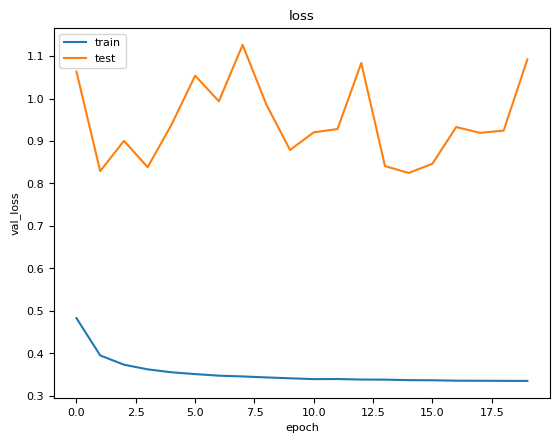

KeyError: 'dice_coef'

In [202]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
                         
plt.plot(history.history['IoU_coeff'])
plt.plot(history.history['val_IoU_coeff'])
plt.title('io_u_7')
plt.ylabel('io_u_7')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [120]:
x_test = np.concatenate(strat_test_seg['im']).reshape(len(strat_test_seg), PDIM[0], PDIM[1], 3)
y_test = np.concatenate(strat_test_seg['mask']).reshape(len(strat_test_seg), PDIM[0], PDIM[1], 1)

In [200]:
y_test.shape

(54307, 5)

In [199]:
y_train.shape

(162698, 5)

In [121]:
predicted_test = model.predict(x_test)

24/24 [==============================] - 44s 2s/step


In [187]:
pp = predicted_test / 255

In [188]:
for i in range(0, len(predicted_test)): 
    m = predicted_test[i].max()
    if m > .8: 
        print(i)

In [196]:
y_test.shape

(54307, 5)

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x2eb0146a0>)

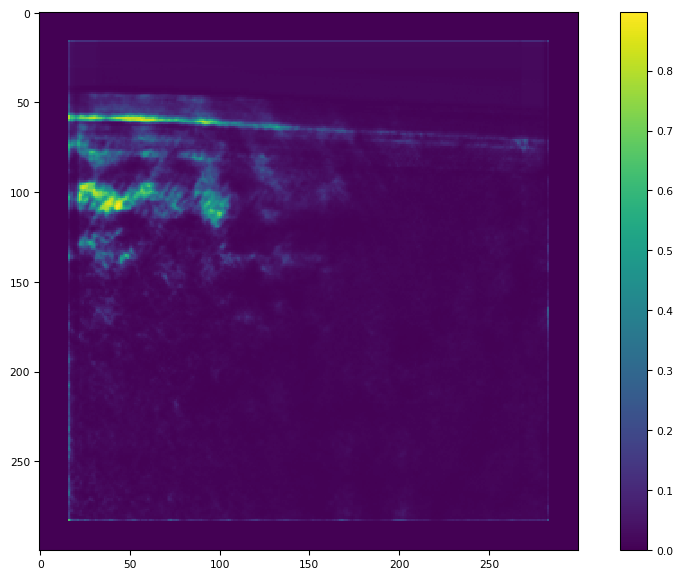

In [190]:
tiff.imshow(predicted_test[565])

In [124]:
# Evaluate model predictions 



In [ ]:
# Cut out the image to use for categorization prediction
predicted_test[0].shape

## Train Model for Categorization

In [146]:
def prepare(dataframe, path, dimensions): 
    for l in tqdm(range(0, len(dataframe))): 
        path_image = '../data/' + path + '/images/' + dataframe['image_name'][l].split(".json")[0] + ".png"
        img = cv2.imread(path_image)

        resize = cv2.resize(img, dimensions, interpolation = cv2.INTER_AREA)
        # resize = [item for sublist in resize for item in sublist]
        img = resize / 255
        dataframe['im'][l] = img

    return dataframe

In [147]:
dir_path = "../data/classification_images/"
success_uids = os.listdir(dir_path)

strat_train = pd.read_csv('../data/training_data.csv').reset_index()
strat_train['im'] = None
strat_train['label'] = strat_train['classification'].map({'no-damage': 0, 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3, 'un-classfied': 4})

strat_test = pd.read_csv('../data/validation_data.csv').reset_index()
strat_test['im'] = None
strat_test['label'] = strat_test['classification'].map({'no-damage': 0, 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3, 'un-classfied': 4})


In [148]:
strat_train = prepare(strat_train, 'train', (35, 35))
x_train = strat_train['im']
x_train = np.concatenate(x_train).reshape(len(strat_train), 35, 35, 3)


  0%|          | 0/162698 [00:00<?, ?it/s]/var/folders/sx/gfq_y8592_bdyxcm2vgcj7dc0000gp/T/ipykernel_87762/3291486104.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['im'][l] = img
100%|██████████| 162698/162698 [1:11:20<00:00, 38.01it/s]


In [149]:
strat_test = prepare(strat_test, 'hold', (35, 35))
x_test = strat_test['im']
x_test = np.concatenate(x_test).reshape(len(strat_test), 35, 35, 3)

  0%|          | 0/54307 [00:00<?, ?it/s]/var/folders/sx/gfq_y8592_bdyxcm2vgcj7dc0000gp/T/ipykernel_87762/3291486104.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['im'][l] = img
100%|██████████| 54307/54307 [23:14<00:00, 38.93it/s]


In [152]:
num_classes = 5
y_train = keras.utils.to_categorical(strat_train['label'], num_classes)
y_test = keras.utils.to_categorical(strat_test['label'], num_classes)

In [153]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(35, 35, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [155]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 35, 35, 75)        2100      
                                                                 
 batch_normalization_17 (Bat  (None, 35, 35, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 75)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 18, 18, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 18, 18, 50)        0         
                                                                 
 batch_normalization_18 (Bat  (None, 18, 18, 50)       2

In [156]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

In [157]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
5085/5085 [==============================] - 139s 27ms/step - loss: 0.4827 - acc: 0.8293 - f1_m: 0.8267 - precision_m: 0.8645 - recall_m: 0.7933 - val_loss: 1.0634 - val_acc: 0.5931 - val_f1_m: 0.4662 - val_precision_m: 0.5062 - val_recall_m: 0.4541
Epoch 2/20
5085/5085 [==============================] - 142s 28ms/step - loss: 0.3949 - acc: 0.8545 - f1_m: 0.8522 - precision_m: 0.8862 - recall_m: 0.8218 - val_loss: 0.8290 - val_acc: 0.7303 - val_f1_m: 0.6678 - val_precision_m: 0.6909 - val_recall_m: 0.6590
Epoch 3/20
5085/5085 [==============================] - 138s 27ms/step - loss: 0.3732 - acc: 0.8607 - f1_m: 0.8591 - precision_m: 0.8908 - recall_m: 0.8306 - val_loss: 0.9003 - val_acc: 0.7272 - val_f1_m: 0.6996 - val_precision_m: 0.7153 - val_recall_m: 0.6935
Epoch 4/20
5085/5085 [==============================] - 138s 27ms/step - loss: 0.3622 - acc: 0.8631 - f1_m: 0.8617 - precision_m: 0.8927 - recall_m: 0.8337 - val_loss: 0.8383 - val_acc: 0.7161 - val_f1_m: 0.6335 - val

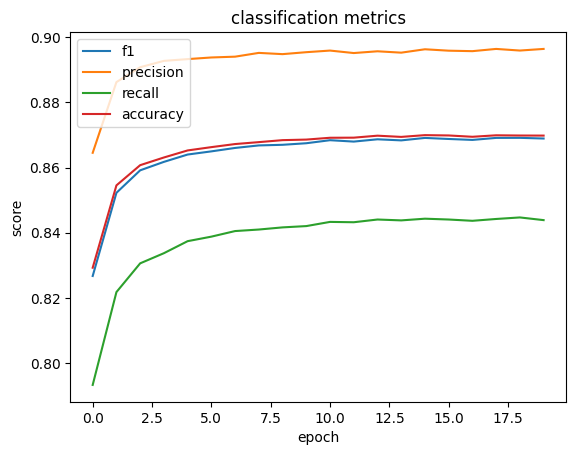

In [159]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['precision_m'])
plt.plot(history.history['recall_m'])
plt.plot(history.history['acc'])
plt.title('classification metrics')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['f1', 'precision', 'recall', 'accuracy'], loc='upper left')
plt.show()

In [201]:
x_train.shape

(162698, 35, 35, 3)